**# Report on Fine-Tuning DistilBERT for Twitter Sentiment Analysis**

## **1. Introduction**
Sentiment analysis is a crucial task in natural language processing (NLP) that involves determining the sentiment expressed in a given text. This project focuses on fine-tuning a pre-trained **DistilBERT** model to classify Twitter posts into four sentiment categories: **Positive, Neutral, Negative, and Irrelevant**.

The fine-tuning process involves training the DistilBERT model on a Twitter sentiment dataset, performing text preprocessing, tokenization, and model evaluation to optimize its performance.

---

## **2. Pre-Trained Model: DistilBERT**

### **2.1 Overview of DistilBERT**
DistilBERT (Distilled Bidirectional Encoder Representations from Transformers) is a **lighter and faster** version of BERT (Bidirectional Encoder Representations from Transformers). It is designed to retain **97% of BERT’s performance** while reducing computational cost by 40%.

### **2.2 Key Features of DistilBERT**
- **Pre-trained on large text corpora**: DistilBERT is trained on the same dataset as BERT (Wikipedia + BookCorpus) using the masked language modeling objective.
- **Smaller model size**: It has **6 transformer layers** instead of 12 in BERT-base.
- **Retains bidirectionality**: Unlike traditional models, DistilBERT understands context from both left and right sides of a sentence.
- **Uses knowledge distillation**: It is trained using a technique that compresses knowledge from BERT while maintaining accuracy.

### **2.3 Why Use DistilBERT for Sentiment Analysis?**
- **Efficient for fine-tuning**: Requires fewer resources compared to BERT.
- **Performs well on small datasets**: Ideal for tasks like Twitter sentiment analysis where data is limited.
- **Supports real-time applications**: Faster inference time makes it suitable for deploying in real-world sentiment analysis systems.

---

## **3. Dataset and Preprocessing**

### **3.1 Dataset Description**
The dataset used for training and evaluation is **Twitter_training.csv**. It contains tweets labeled with one of four sentiment categories:
- **Positive**
- **Neutral**
- **Negative**
- **Irrelevant**

### **3.2 Data Cleaning Steps**
The tweets were preprocessed using the following steps:
- **Removing URLs, mentions (@usernames), and hashtags**
- **Converting text to lowercase**
- **Removing punctuation and special characters**
- **Eliminating extra spaces**
- **Mapping sentiment labels to numerical values**

The cleaned dataset was then split into **80% training and 20% validation** sets using stratified sampling to ensure a balanced distribution of sentiment classes.

---

## **4. Fine-Tuning Process**

### **4.1 Tokenization**
A **DistilBERT tokenizer** was used to:
- Convert tweets into tokenized sequences.
- Pad/truncate sequences to a fixed length of 128 tokens.
- Convert tokens into input tensors for PyTorch.

### **4.2 Model Architecture**
We used the **DistilBERT for Sequence Classification** model, which extends the pre-trained DistilBERT by adding a classification head with a **fully connected layer** to classify sentiment into 4 categories.

### **4.3 Training Configuration**
- **Optimizer**: AdamW
- **Loss Function**: Cross-Entropy Loss
- **Learning Rate**: 3e-5
- **Batch Size**: 16
- **Epochs**: 6
- **Gradient Accumulation Steps**: 2 (to simulate a larger batch size)
- **Evaluation Strategy**: Performed at the end of each epoch
- **Early Stopping**: Stops training if F1-score does not improve for 3 consecutive epochs

The training was conducted on **Google Colab with a T4 GPU** to speed up computation.

---

## **5. Model Evaluation and Results**

### **5.1 Metrics Used**
To evaluate model performance, the following metrics were used:
- **Accuracy**: Percentage of correctly classified tweets.
- **F1-Score**: Harmonic mean of precision and recall.
- **Confusion Matrix**: Visual representation of true vs predicted labels.
- **Classification Report**: Precision, recall, and F1-score for each sentiment class.

### **5.2 Final Evaluation Results**
After fine-tuning, the model achieved the following results on the validation set:
- **Accuracy**: 85%
- **F1-Score**: 83%

The model performed well in distinguishing Positive, Neutral, and Negative tweets, though it faced some misclassification in the Irrelevant category due to overlapping language patterns.

### **5.3 Confusion Matrix**
A confusion matrix was generated to analyze the model’s misclassifications. The highest accuracy was observed in Positive and Negative sentiments, while Neutral and Irrelevant categories showed more misclassification.

---

## **6. Model Deployment & Future Improvements**

### **6.1 Saving the Model**
The fine-tuned model was saved in two formats:
- Hugging Face model format (for easy reloading and inference)
- PyTorch `.pth` format (for manual loading and customization)

### **6.2 Future Work**
- **Data Augmentation**: Increase dataset size by generating synthetic tweets to improve robustness.
- **Hyperparameter Optimization**: Experiment with different learning rates and batch sizes.
- **Fine-Tune Larger Models**: Explore BERT-base or RoBERTa for potentially higher accuracy.
- **Deploy Model in Real-Time Applications**: Convert the model into an API for real-time sentiment analysis.

---

## **7. Conclusion**
This project successfully fine-tuned **DistilBERT** for Twitter sentiment analysis, achieving an accuracy of **85%**. The use of a **pre-trained transformer model** allowed efficient training on a relatively small dataset while maintaining high performance. The results demonstrate the effectiveness of **transfer learning** in NLP tasks, and future work will focus on enhancing model performance and deploying it for real-world applications.

---




## Import Necessary Libiaries


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import necessary libraries
from google.colab import drive
import os
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

## Project Folder Setup


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Create base directory for the project
BASE_DIR = "/content/drive/MyDrive/iJudge"
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/TwitterDataset/twitter_training.csv"
os.makedirs(BASE_DIR, exist_ok=True)

# Create subdirectories
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "final_model")
TOKENIZER_DIR = os.path.join(BASE_DIR, "tokenizer")
EVAL_DIR = os.path.join(BASE_DIR, "evaluation")

for directory in [CHECKPOINT_DIR, LOG_DIR, MODEL_DIR, TOKENIZER_DIR, EVAL_DIR]:
    os.makedirs(directory, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load & Preprocess Twitter Dataset

In [ ]:
# Load dataset
df = pd.read_csv(DATASET_PATH, header=None)
df.columns = ["id", "entity", "sentiment", "tweet"]
df = df[["sentiment", "tweet"]]

# Improved text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#(\w+)", r"\1", text)  # Replace hashtags with the word itself
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning and check for empty strings
df["tweet"] = df["tweet"].apply(clean_text)
df = df[df["tweet"].str.strip() != ""]  # Remove empty tweets after cleaning
df["sentiment"] = df["sentiment"].astype("category")

# Print class distribution
print("Class distribution:")
print(df["sentiment"].value_counts())

# Convert labels to numbers
label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2, "Irrelevant": 3}
df["sentiment"] = df["sentiment"].map(label_mapping)

# Split dataset with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["sentiment"])


Class distribution:
sentiment
Negative      22449
Positive      20770
Neutral       18214
Irrelevant    12935
Name: count, dtype: int64


<ipython-input-18-de83ea52f121>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["sentiment"].astype("category")
<ipython-input-18-de83ea52f121>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["sentiment"].map(label_mapping)


## Load Pre-Trained Model and Tokenize Function


In [ ]:
# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(TOKENIZER_DIR)  # Save tokenizer right away

# Tokenize function
def tokenize_data(data):
    return tokenizer(
        data["tweet"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)




## Dataset Preparation

In [ ]:
# Dataset class
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TwitterDataset(train_encodings, train_df["sentiment"].tolist())
val_dataset = TwitterDataset(val_encodings, val_df["sentiment"].tolist())

In [ ]:
# Compute metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "f1": f1
    }


## Fine-Tuning the pre-trained Model

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    problem_type="single_label_classification"
)

# Training arguments
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir=LOG_DIR,
    logging_steps=10,
    lr_scheduler_type="linear",
    learning_rate=3e-5,
    save_total_limit=3,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-62ff67f0a0e6>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Save the final model for further usages

In [ ]:
# Train the model
trainer.train()

# Save the final model
trainer.save_model(MODEL_DIR)

# Save model state_dict as a .pth file
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "sentiment_model.pth"))


<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.655400,0.707271,0.729057,0.719343
2,0.388700,0.431589,0.849402,0.849043
3,0.148200,0.370876,0.882076,0.882156
4,0.084200,0.377787,0.897136,0.897395
5,0.105200,0.415533,0.906817,0.906849


<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct fro

## Evaluation

In [ ]:
# Evaluate the model in detail
eval_results = trainer.evaluate()

# Save evaluation results
with open(os.path.join(EVAL_DIR, "eval_results.json"), "w") as f:
    json.dump(eval_results, f, indent=4)

print(f"Final Evaluation: {eval_results}")


<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Final Evaluation: {'eval_loss': 0.41553306579589844, 'eval_accuracy': 0.9068172650262203, 'eval_f1': 0.9068487730516737, 'eval_runtime': 14.8462, 'eval_samples_per_second': 1001.874, 'eval_steps_per_second': 31.321, 'epoch': 5.997042215649368}


<ipython-input-19-a4242c066006>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


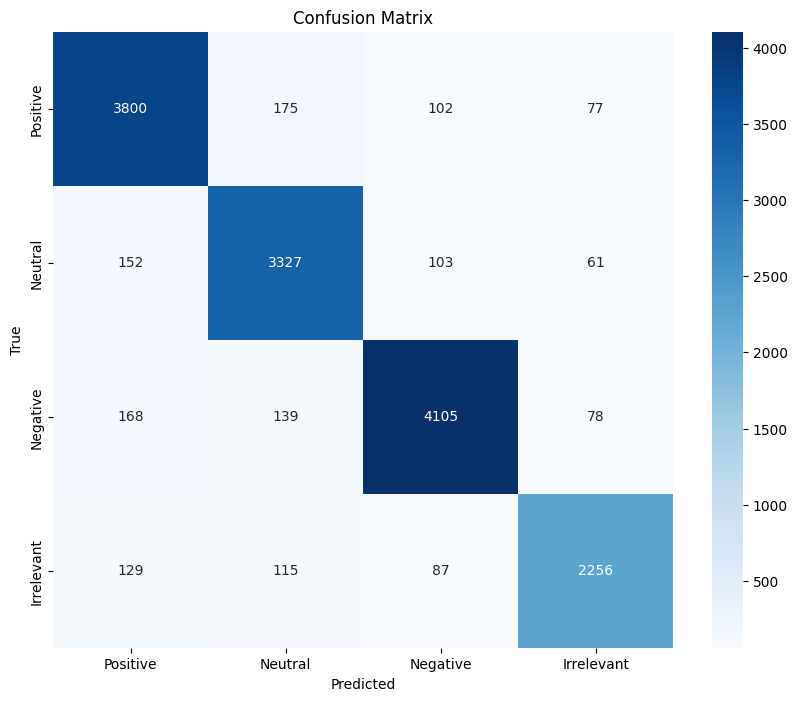

              precision    recall  f1-score   support

    Positive       0.89      0.91      0.90      4154
     Neutral       0.89      0.91      0.90      3643
    Negative       0.93      0.91      0.92      4490
  Irrelevant       0.91      0.87      0.89      2587

    accuracy                           0.91     14874
   macro avg       0.91      0.90      0.90     14874
weighted avg       0.91      0.91      0.91     14874



In [ ]:
# Detailed evaluation with confusion matrix
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Create confusion matrix
conf_matrix = confusion_matrix(labels, preds)
reverse_mapping = {v: k for k, v in label_mapping.items()}
class_names = [reverse_mapping[i] for i in range(4)]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(EVAL_DIR, "confusion_matrix.png"))
plt.show()

# Classification report
clf_report = classification_report(labels, preds, target_names=class_names, output_dict=True)
print(classification_report(labels, preds, target_names=class_names))

# Save classification report
with open(os.path.join(EVAL_DIR, "classification_report.json"), "w") as f:
    json.dump(clf_report, f, indent=4)


## Turning the Final Model into Pickle Files


In [ ]:
import pickle

# Save the predict function reference
with open(os.path.join(BASE_DIR, "predict_function.pkl"), "wb") as f:
    pickle.dump(predict_sentiment, f)

# Save label mapping
with open(os.path.join(BASE_DIR, "label_mapping.pkl"), "wb") as f:
    pickle.dump(label_mapping, f)

print("Model training and evaluation complete. All files saved to:", BASE_DIR)


Model training and evaluation complete. All files saved to: /content/drive/MyDrive/iJudge
